In [1]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import os
from tqdm.notebook import tqdm
import py3Dmol

import oddt
from oddt.scoring.functions.PLECscore import PLECscore
from oddt.scoring.functions import RFScore
from oddt.scoring.functions import NNScore

def plot_scores(x, y):
    fig, ax = plt.subplots()
    ax.scatter(x, y, label=f'Spearman: { np.around(spearmanr(x,y)[0],3)}')
    ax.axhline(50, c='k', linestyle='--')
    ax.axhline(0, c='gray', linestyle='-')
    ax.axhline(100, c='gray', linestyle='-')
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
    ax.legend()
    return fig, ax

def viewProt(mol, view=None):
    if view is None:
        view = py3Dmol.view()
    view.addModel(Chem.MolToMolBlock(mol), "sdf")
    view.addStyle({"model": 0}, {"stick": {"colorscheme": "orangeCarbon"}})
    view.zoomTo()
    return view

# Load inhibition data from Lyu et al


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Energy', ylabel='Inhibition (%) at 10uM'>)

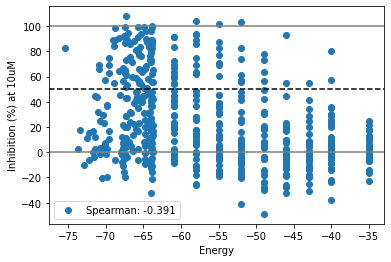

In [2]:
df = pd.read_csv('./data/41586_2019_917_MOESM4_ESM.csv',).iloc[:-4]
df['Inhibition (%) at 10uM'] = df['Inhibition (%) at 10uM'].astype(float)

plot_scores(df['Energy'], df['Inhibition (%) at 10uM'])


# Load docked structures

In [3]:
def load_sdf(fname):
    mols = []
    with Chem.SDMolSupplier(fname) as sup:
        for m in sup:
            if m is not None:
                mols.append(m)
    names = [m.GetProp('_Name') for m in mols]
    affinities = [float(m.GetProp('minimizedAffinity')) for m in mols]
    return pd.DataFrame({'mol':mols, 'ZINC ID':names, 'Smina Score':affinities})


In [4]:
mols_df = load_sdf('./data/ligands3d_docked.sdf')
#note; a few of the Gypsum-treated molecules can't be read by RDKit.
#could possibly be due to smina using obabel to convert to pdbqt and back?
mols_gypsum_df = load_sdf('./data/ligands3d_gypsum_docked.sdf')
mols_gypsum_df = mols_gypsum_df.rename(columns={'ZINC ID': 'ZINC ID.items'})
mols_gypsum_df['ZINC ID'] = [i[0] for i in mols_gypsum_df['ZINC ID.items'].str.split()]

RDKit ERROR: [15:45:19] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:45:19] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [15:45:19] ERROR: Could not sanitize molecule ending on line 873123
RDKit ERROR: [15:45:19] ERROR: Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [15:45:19] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [15:45:19] ERROR: Could not sanitize molecule ending on line 873186
RDKit ERROR: [15:45:19] ERROR: Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [15:45:19] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [15:45:19] ERROR: Could not sanitize molecule ending on line 873249
RDKit ERROR: [15:45:19] ERROR: Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [15:45:19] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [15:45:19] ERROR: Could not sanitize molecule en

# Add some re-scoring scores


In [5]:
def re_score(method, mols):
    """
    Method is one of: 
    - PLEClinear_p5_l1_s65536
    - rfscore_v1
    - nnscore
    """
    rescorers = {'PLEClinear_p5_l1_s65536':PLECscore('rf'),
                'rfscore_v1':RFScore.rfscore(),
                'nnscore':NNScore.nnscore()}
    
    pickles = {'PLEClinear_p5_l1_s65536':'./data/PLEClinear_p5_l1_pdbbind2016_s65536.pickle',
               'rfscore_v1':'./data/RFScore_v1_pdbbind2016.pickle',
               'nnscore':'./data/NNScore_pdbbind2016.pickle'}

    scorer = rescorers[method]

    if os.path.isfile(pickles[method]):
        scorer = scorer.load(pickles[method])
    else:
        scorer.train()
    
    oddt_prot = next(oddt.toolkit.readfile('pdb', './data/proteinH.pdb'))
    oddt_prot.protein=True 
    scorer.set_protein(oddt_prot)

    re_scores = []

    for m in tqdm(mols, total=len(mols)):
        Chem.MolToMolFile(m, './temp.sdf')
        oddt_lig = next(oddt.toolkit.readfile('sdf', './temp.sdf'))
        scored_mol = scorer.predict_ligand(oddt_lig)
        re_scores.append(float(scored_mol.data[method]))
    os.remove('./temp.sdf')
        
    return re_scores

In [7]:
rfscores = re_score('rfscore_v1',mols_df['mol'])
plecscores = re_score('PLEClinear_p5_l1_s65536',mols_df['mol'])
nnscores = re_score('nnscore',mols_df['mol'])

rfscores_gypsum = re_score('rfscore_v1',mols_gypsum_df['mol'])
plecscores_gypsum = re_score('PLEClinear_p5_l1_s65536',mols_gypsum_df['mol'])
nnscores_gypsum = re_score('nnscore',mols_gypsum_df['mol'])

  0%|          | 0/4933 [00:00<?, ?it/s]

  0%|          | 0/4933 [00:00<?, ?it/s]

  0%|          | 0/4933 [00:00<?, ?it/s]

  0%|          | 0/19146 [00:00<?, ?it/s]

  0%|          | 0/19146 [00:00<?, ?it/s]

  0%|          | 0/19146 [00:00<?, ?it/s]

In [8]:
mols_df['RFScore'] = rfscores
mols_df['PLECScore'] = plecscores
mols_df['NNSCore'] = nnscores

mols_gypsum_df['RFScore'] = rfscores_gypsum
mols_gypsum_df['PLECScore'] = plecscores_gypsum
mols_gypsum_df['NNSCore'] = nnscores_gypsum

# Add a benchmark based on similarity to the known ligand
Benchmark just means it doesn't require machine learning and is readily available to anyone, but the original work is clever and sophisticated - see [this blog post by Greg Landrum](http://rdkit.blogspot.com/2017/11/using-feature-maps.html) for references.

In [9]:
# set up the reference ligand feature map:

from rdkit import RDConfig
from rdkit.Chem.FeatMaps import FeatMaps
import requests

pdb = Chem.MolFromPDBFile('./data/AQD_ligand.pdb')
aqd_smi = 'C[C@@H]1[C@@H](CCN1Cc2ccccc2)NC(=O)c3cc(c(cc3OC)NC)Cl'
aqd_mol = Chem.MolFromSmiles(aqd_smi)
pdb = AllChem.AssignBondOrdersFromTemplate(aqd_mol, pdb)

# grab a feature definition file from the RDKit's contrib dir in github:
res = requests.get('https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/M_Kossner/BaseFeatures_DIP2_NoMicrospecies.fdef')
fdef = res.text
factory = Chem.ChemicalFeatures.BuildFeatureFactoryFromString(fdef)
#make the features for the reference molecule:
feats = factory.GetFeaturesForMol(pdb)
fmParams = {}
for k in factory.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams
    
wts = [1 for _ in feats]
fms = FeatMaps.FeatMap(feats=feats, weights=wts, params=fmParams)

In [11]:
def get_fmvs(fms, mols):
    fmvs = []
    for mol in tqdm(mols):
        qfeat= factory.GetFeaturesForMol(mol)    
        fmv = fms.ScoreFeats(qfeat) / fms.GetNumFeatures() 
        fmvs.append(fmv)
    return fmvs

fmvs = get_fmvs(fms, mols_df['mol'])
fmvs_gypsum = get_fmvs(fms, mols_gypsum_df['mol'])


  0%|          | 0/4933 [00:00<?, ?it/s]

  0%|          | 0/19146 [00:00<?, ?it/s]

In [12]:
mols_df['Feature Map Vector score'] = fmvs
mols_gypsum_df['Feature Map Vector score'] = fmvs_gypsum

# Add RFScore-VS-v1
This can't be run in a notebook - but there is a binary available [at this repo](https://github.com/oddt/rfscorevs_binary). Run command is (for example):

```
cd ./data/
path_to_binary/rf-score-vs_v1/rf-score-vs --receptor ./proteinH.pdb ./ligands3d_docked.sdf -O ./rfscorevs.csv
path_to_binary/rf-score-vs_v1/rf-score-vs --receptor ./proteinH.pdb ./ligands3d_gypsum_docked.sdf -O ./rfscorevs_gypsum.csv
```



In [124]:
rf_score_vs = pd.read_csv('./data/rfscorevs.csv')
rf_score_vs_gypsum = pd.read_csv('./data/rfscorevs_gypsum.csv')


mols_df['RF Score VS'] = rf_score_vs['RFScoreVS_v2']
mols_gypsum_df['RF Score VS'] = rf_score_vs_gypsum['RFScoreVS_v2']

# Plot the outcomes

For each re-scoring technique, we sort in order of best->worst, retain only the best-scoring conformer, and merge this with the inhibition data frame. Plotting the ROCs, and calculating some metrics, reveals which re-scoring technique performs best on these data.

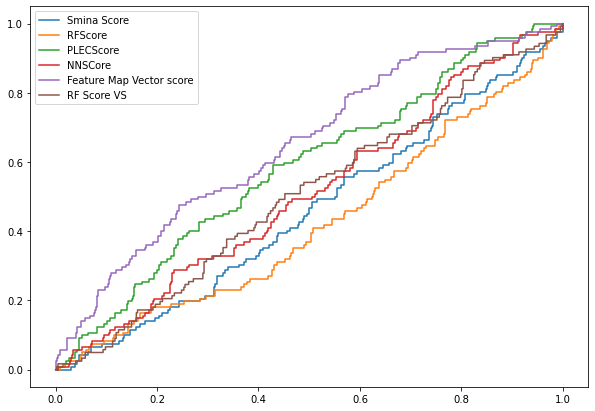

In [126]:
from sklearn.metrics import average_precision_score as avp
from sklearn.metrics import plot_precision_recall_curve, roc_curve
from oddt import metrics

results = []
plt.figure(figsize=(10,7))
for col, ascending in zip(
    ['Smina Score', 'RFScore', 'PLECScore', 'NNSCore', 'Feature Map Vector score','RF Score VS'],
    [True, False, False, False, False, False]
):
    
    srtd = mols_df.sort_values(col, ascending=ascending).drop_duplicates('ZINC ID')
    merged= srtd.merge(df[['ZINC ID', 'Inhibition (%) at 10uM']])
    labels = merged['Inhibition (%) at 10uM']>50
    preds = merged[col]
    
    
    fpr, tpr, thresholds= roc_curve(labels, preds)
    plt.plot(fpr, tpr, label=col)
    
    bedroc = metrics.bedroc(labels.values, merged[col].values)
    rie = metrics.rie(labels.values, merged[col].values)
    roc_log_auc = metrics.roc_log_auc(labels.values, merged[col].values, ascending_score=ascending)
    roc_auc = metrics.roc_auc(labels.values, merged[col].values, ascending_score=ascending)
    
    ap = avp(labels,  preds*(-1 if ascending else 1))
    
    results.append([col, bedroc, rie, roc_log_auc, roc_auc, ap])
plt.legend()

plt.savefig('./figs/rocs.svg')

In [127]:
results_df = pd.DataFrame(data=results, columns=['Algorithm', 'BEDROC', 'RIE', 'log ROC AUC', 'ROC AUC', 'Average Precision'])

In [128]:
results_df.set_index('Algorithm').style.highlight_max(color = 'lightgreen', axis = 0)

,BEDROC,RIE,log ROC AUC,ROC AUC,Average Precision
Algorithm,,,,,
Smina Score,0.307874,1.369165,0.173498,0.542481,0.271476
RFScore,0.186356,0.828755,0.116837,0.422736,0.195528
PLECScore,0.281182,1.250461,0.178505,0.584079,0.271272
NNSCore,0.223528,0.994065,0.145951,0.509464,0.228881
Feature Map Vector score,0.439266,1.953485,0.233527,0.649096,0.359716
RF Score VS,0.180401,0.802271,0.142105,0.505730,0.225434


# The gypsum-treated molecules:


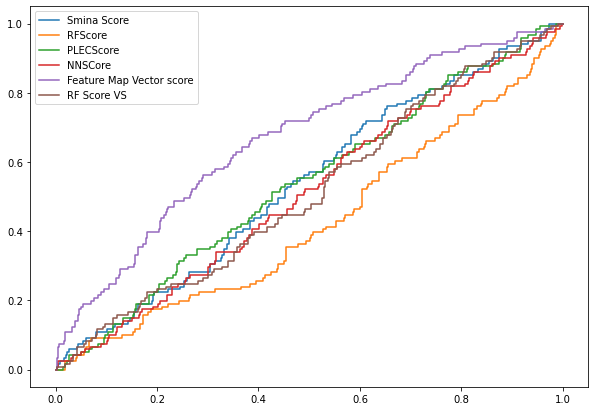

In [151]:
results_gypsum = []
plt.figure(figsize=(10,7))
for col, ascending in zip(
    ['Smina Score', 'RFScore', 'PLECScore', 'NNSCore', 'Feature Map Vector score','RF Score VS'],
    [True, False, False, False, False, False]
):
    
    srtd = mols_gypsum_df.sort_values(col, ascending=ascending).drop_duplicates('ZINC ID')
    merged= srtd.merge(df[['ZINC ID', 'Inhibition (%) at 10uM']])
    labels = merged['Inhibition (%) at 10uM']>50
    preds = merged[col]
    
    
    fpr, tpr, thresholds= roc_curve(labels, preds*(-1 if ascending else 1))
    plt.plot(fpr, tpr, label=col)
    
    bedroc = metrics.bedroc(labels.values, merged[col].values)
    rie = metrics.rie(labels.values, merged[col].values)
    roc_log_auc = metrics.roc_log_auc(labels.values, merged[col].values, ascending_score=ascending)
    roc_auc = metrics.roc_auc(labels.values, merged[col].values, ascending_score=ascending)
    
    ap = avp(labels,  preds*(-1 if ascending else 1))
    
    results_gypsum.append([col, bedroc, rie, roc_log_auc, roc_auc, ap])
plt.legend()

plt.savefig('./figs/rocs_gypsum.svg')

In [152]:
results_df_gypsum = pd.DataFrame(data=results_gypsum, columns=['Algorithm', 'BEDROC', 'RIE', 'log ROC AUC', 'ROC AUC', 'Average Precision'])
results_df_gypsum.set_index('Algorithm').style.highlight_max(color = 'lightgreen', axis = 0)

,BEDROC,RIE,log ROC AUC,ROC AUC,Average Precision
Algorithm,,,,,
Smina Score,0.276897,1.238894,0.161958,0.537964,0.248890
RFScore,0.193804,0.867121,0.117978,0.425281,0.195885
PLECScore,0.215919,0.966067,0.154239,0.537461,0.237679
NNSCore,0.222201,0.994176,0.148586,0.510945,0.231993
Feature Map Vector score,0.487587,2.181567,0.249716,0.668434,0.379470
RF Score VS,0.245984,1.100586,0.149911,0.512610,0.232820


In [154]:
(df['Inhibition (%) at 10uM']>50).sum()

122